In [1]:
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import backtrader as bt
import math

import datetime

In [2]:
from data import *

In [4]:
data = load_dir('./data')

In [6]:
symbols = data.symbol.unique()

In [11]:
import datetime
first_day = datetime.datetime.now().replace(day=1)
prev_mon_last_day = first_day - datetime.timedelta(days = 1)
print(prev_mon_last_day.strftime('%Y-%m'))

2019-02


In [4]:
%matplotlib inline

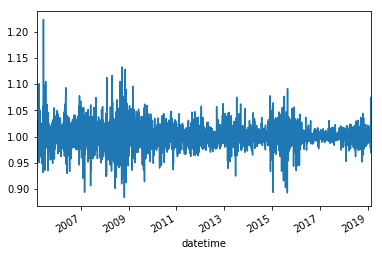

In [33]:
data.index =pd.to_datetime(data.index)
sym = symbols[0]
data0 = data[data.symbol == sym]
close = data0.close
ret = (close / close.shift(1))
ret.plot()
mstr = prev_mon_last_day.strftime('%Y-%m')


In [3]:
import datetime
def momentum(data, end_date= datetime.datetime.today(), timespan=1):
    from dateutil.relativedelta import relativedelta
    data.index =pd.to_datetime(data.index)
    
    close = data.close
    day_ret = close / close.shift(1)
    
    prev_month = end_date - relativedelta( months= 1)
    
    prev_start_month = prev_month -relativedelta(months = timespan -1)
    
    fmt_str = '%Y-%m'
    pmon_str, psmon_str = prev_month.strftime(fmt_str), prev_start_month.strftime(fmt_str)
    
    print(pmon_str, psmon_str)
    range_ret = day_ret[ pmon_str : psmon_str]
    if timespan == 1 :
        range_ret = day_ret[prev_month.strftime(fmt_str)]
    return range_ret.cumprod()[-1] -1 
    

In [57]:
for sym in symbols:
    dsym = data[data.symbol == sym]
    short_ret = momentum(dsym)
    inter_ret = momentum(dsym , timespan = 12)
    long_ret = momentum(dsym, timespan = 12*5 )
    
    msg = '%s: s_ret: %.2f inter_ret: %.2f long_ret: %.2f' % (sym, short_ret, inter_ret, long_ret)
    print(msg)

2019-02 2019-02
2019-02 2018-03
2019-02 2014-03
50ETF:510050: s_ret: 0.11 inter_ret: -0.03 long_ret: 1.17
2019-02 2019-02
2019-02 2018-03
2019-02 2014-03
中:159902: s_ret: 0.21 inter_ret: -0.20 long_ret: 0.23
2019-02 2019-02
2019-02 2018-03
2019-02 2014-03
深成ETF:159903: s_ret: 0.20 inter_ret: -0.15 long_ret: 0.29
2019-02 2019-02
2019-02 2018-03
2019-02 2014-03
超大ETF:510020: s_ret: 0.11 inter_ret: -0.01 long_ret: 0.92
2019-02 2019-02
2019-02 2018-03
2019-02 2014-03
中小ETF:510220: s_ret: 0.18 inter_ret: -0.08 long_ret: 0.55
2019-02 2019-02
2019-02 2018-03
2019-02 2014-03
中小300:159907: s_ret: 0.20 inter_ret: -0.19 long_ret: 0.21
2019-02 2019-02
2019-02 2018-03
2019-02 2014-03
民营ETF:159911: s_ret: 0.23 inter_ret: -0.17 long_ret: 0.13
2019-02 2019-02
2019-02 2018-03
2019-02 2014-03
深300ETF:159912: s_ret: 0.19 inter_ret: -0.14 long_ret: 0.36
2019-02 2019-02
2019-02 2018-03
2019-02 2014-03
100ETF:159923: s_ret: 0.13 inter_ret: -0.07 long_ret: 0.99
2019-02 2019-02
2019-02 2018-03
2019-02 2014-03

In [13]:
from backtrader.analyzers import (Returns, DrawDown,TradeAnalyzer)


In [5]:
import datetime
today = datetime.datetime.today()

In [6]:
yesterday = today - datetime.timedelta(days = 1)
today.month - yesterday.month

0

In [10]:
def run_backtest(data, init_cash, strategy, **args):
    cerebro = bt.Cerebro()
    print(args)

    # Add a strategy
    cerebro.addstrategy(strategy, **args)


    # Create a Data Feed
    datafeed = bt.feeds.PandasData(dataname=data, datetime=None)

    # Add the Data Feed to Cerebro
    cerebro.adddata(datafeed)

    # Set our desired cash start
    cerebro.broker.setcash(init_cash)
    cerebro.addobserver(bt.observers.DrawDown)

    # Add a FixedSize sizer according to the stake
    #cerebro.addsizer(bt.sizers.FixedSize, stake=3000)

    # Set the commission - 0.1% ... divide by 100 to remove the %
    cerebro.broker.setcommission(commission=0.001)
    cerebro.addanalyzer(Returns, _name='r1')
    cerebro.addanalyzer(DrawDown, _name='dd')
    cerebro.addanalyzer(TradeAnalyzer, _name='ta')
    cerebro.addanalyzer(bt.analyzers.TimeReturn, timeframe=bt.TimeFrame.Years, _name='y_r')

    # Print out the starting conditions
    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

    # Run over everything
    strat = cerebro.run()

    # Print out the final result
    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())
    
    return (cerebro,strat)


In [53]:
class PeriodStrategy(bt.Strategy):
    params =(
    )
    
    def next(self):
        dt = self.data.datetime.date()
        prev_dt = self.data.datetime.date() - datetime.timedelta(days=1)
        
        dt_mon = dt.month
        prev_mon = prev_dt.month
        if abs(dt_mon - prev_mon) and dt_mon % 3==0  :
            size = math.floor(2000 / (self.data * 100)) * 100
            value = self.broker.getvalue()
            print('{0} buy {1} on price {2:.2f} value:{3:d}'.format(dt, size, self.data[0], self.position.size))
            self.order = self.buy(size=size)

In [29]:
data = get_test_data('.\data', start='2005', file_index=2)


深成ETF:159903


In [9]:
data2 = data['2010':]

In [54]:
cerebro, strat = run_backtest(data2, 100000, PeriodStrategy)

{}
Starting Portfolio Value: 100000.00
2010-03-01 buy 1500 on price 1.26 value:0
2010-06-01 buy 1900 on price 1.01 value:1500
2010-09-01 buy 1700 on price 1.14 value:3400
2010-12-01 buy 1600 on price 1.24 value:5100
2011-03-01 buy 1500 on price 1.31 value:6700
2011-06-01 buy 1600 on price 1.19 value:8200
2011-09-01 buy 1700 on price 1.15 value:9800
2011-12-01 buy 1900 on price 1.01 value:11500
2012-03-01 buy 1900 on price 1.02 value:13400
2012-06-01 buy 1900 on price 1.03 value:15300
2013-03-01 buy 2000 on price 0.98 value:17200
2014-09-01 buy 2300 on price 0.84 value:19200
2014-12-01 buy 2000 on price 0.96 value:21500
2015-06-01 buy 1100 on price 1.78 value:23500
2015-09-01 buy 1900 on price 1.04 value:24600
2015-12-01 buy 1500 on price 1.29 value:26500
2016-03-01 buy 2000 on price 0.98 value:28000
2016-06-01 buy 1800 on price 1.07 value:30000
2016-09-01 buy 1700 on price 1.14 value:31800
2016-12-01 buy 1700 on price 1.18 value:33500
2017-03-01 buy 1800 on price 1.11 value:35200
2017-

D:\Anaconda3\lib\site-packages\matplotlib\__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


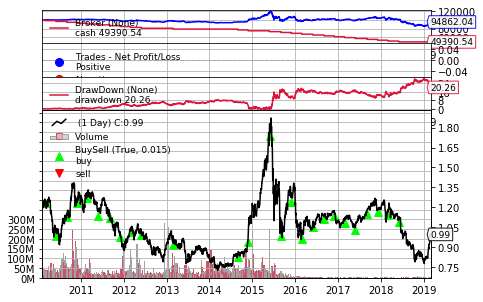

[[<matplotlib.figure.Figure at 0x2088eedcc50>]]

In [55]:
cerebro.plot()

In [106]:
class StratTurtle(bt.Strategy):
    params =(
        ('win', 50),
        ('filterma', 60),
        ('atrf', 2),
        ('atrwin', 20),
        ('risk', 0.02)
    )
    def __init__(self):
        
        fma = bt.indicators.SimpleMovingAverage(
            self.datas[0], period=self.p.filterma)
       
        self.filter = fma
        self.max50 = bt.indicators.Highest(self.data, period=self.p.win)
        self.min50 = bt.indicators.Lowest(self.data, period =self.p.win)
        self.atr =  bt.indicators.ATR(self.data, plot=False, period=self.p.atrwin)
        self.hold_day = 0
        
    def next(self):
        dt = self.data.datetime.date()
        close = self.data.close[0]
        #if close >self.max50[-1] or close < self.min50[-1]:
            #print('{3}--close:{0} past max 50 {1} past min 50:{2} '.format(self.data.close[0], 
            #                                                               self.max50[-1], self.min50[-1], dt.isoformat()))
            #print(self.position.size)
        portfolio_value = self.broker.get_value()
        
        data_value = self.broker.get_value([self.data])
        dd = self.stats.drawdown.drawdown[-1]
        
        if close >=self.max50[-1] and self.position.size == 0:
            size = math.floor(portfolio_value * self.p.risk / (self.p.atrf* 100 * self.atr[0])) * 100
            max_hold = math.floor(self.broker.cash / (close * 110)) * 100
            if max_hold < size :
                #print('size:', size, 'max_hold:', max_hold)
                #print('close:', close, 'cash:', self.broker.cash)
                size = max_hold
                
            self.order = self.order_target_size(target=size)
        
        elif  self.position.size>0 and (close <= self.min50[-1] or close < self.filter):
            self.order = self.order_target_size(target=0)
            
            self.hold_day = 0
            
            
        if self.position.size:
            self.hold_day +=1


In [92]:
years = [str(a) for a in range(2011, 2019)]

In [107]:
for r in range(1, 8):
    cerebro, strat = run_backtest(data['2010':], 10000, StratTurtle, filterma=100, atrf=2 ,risk=r/100.0)
    strat[0].analyzers.r1.print()

{'filterma': 100, 'atrf': 2, 'risk': 0.01}
Starting Portfolio Value: 10000.00
Final Portfolio Value: 12545.71
Returns:
  - rtot: 0.22679329090448652
  - ravg: 0.00010290076719804288
  - rnorm: 0.02627012654993356
  - rnorm100: 2.6270126549933557
{'filterma': 100, 'atrf': 2, 'risk': 0.02}
Starting Portfolio Value: 10000.00
Final Portfolio Value: 14810.53
Returns:
  - rtot: 0.39275354409040913
  - ravg: 0.00017820033760907855
  - rnorm: 0.04593004526808753
  - rnorm100: 4.593004526808753
{'filterma': 100, 'atrf': 2, 'risk': 0.03}
Starting Portfolio Value: 10000.00
Final Portfolio Value: 14843.86
Returns:
  - rtot: 0.39500148821137776
  - ravg: 0.0001792202759579754
  - rnorm: 0.046198909428125635
  - rnorm100: 4.619890942812564
{'filterma': 100, 'atrf': 2, 'risk': 0.04}
Starting Portfolio Value: 10000.00
Final Portfolio Value: 14300.62
Returns:
  - rtot: 0.3577181006615187
  - ravg: 0.0001623040384126673
  - rnorm: 0.0417485690110611
  - rnorm100: 4.17485690110611
{'filterma': 100, 'atrf

In [99]:
cerebro, strat = run_backtest(data['2017':], 100000, StratTurtle, filterma=100, atrf=2)
strat[0].analyzers.ta.print()

{'filterma': 100, 'atrf': 2}
Starting Portfolio Value: 100000.00
Final Portfolio Value: 108775.63
TradeAnalyzer:
  -----------------------------------------------------------------------------
  - total:
    - total: 3
    - open: 1
    - closed: 2
  -----------------------------------------------------------------------------
  - streak:
    +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
    - won:
      - current: 1
      - longest: 1
    +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
    - lost:
      - current: 0
      - longest: 1
  -----------------------------------------------------------------------------
  - pnl:
    +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
    - gross:
      - total: -143.70000000002392
      - average: -71.85000000001196
    +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
    - net:
      - total: -464.0247000000236
      - average: -232.

{'filterma': 100, 'atrf': 2, 'risk': 0.05}
Starting Portfolio Value: 100000.00
size: 178400 max_hold: 105300
close: 0.863 cash: 100000.0
Final Portfolio Value: 113703.32


D:\Anaconda3\lib\site-packages\matplotlib\__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


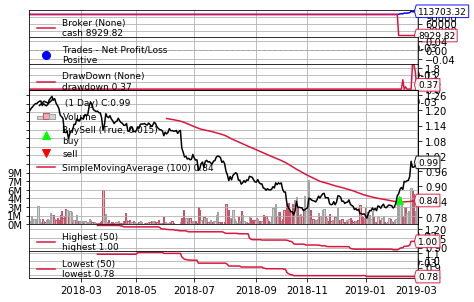

[[<matplotlib.figure.Figure at 0x1b3ddc95c18>]]

In [100]:
cerebro, strat = run_backtest(data['2018':], 100000, StratTurtle, filterma=100, atrf=2 ,risk=0.05)
cerebro.plot()

In [54]:
params =[(a,k) for a in range(2, 6) for k in range(50, 110, 10) ]

In [59]:
for i, j in params:
    cerebro, strat = run_backtest(data2, 100000, StratTurtle, filterma=j, atrf=i)
    strat[0].analyzers.r1.print()
    
#strat[0].analyzers.dd.print()
    
#strat[0].analyzers.y_r.print()

{'filterma': 50, 'atrf': 2}
Starting Portfolio Value: 100000.00
Final Portfolio Value: 134036.46
Returns:
  - rtot: 0.29294164113917637
  - ravg: 0.00013291363028093301
  - rnorm: 0.03406148216968089
  - rnorm100: 3.4061482169680892
{'filterma': 60, 'atrf': 2}
Starting Portfolio Value: 100000.00
Final Portfolio Value: 142473.05
Returns:
  - rtot: 0.3539826940842361
  - ravg: 0.0001606092078422124
  - rnorm: 0.04130373600629662
  - rnorm100: 4.130373600629662
{'filterma': 70, 'atrf': 2}
Starting Portfolio Value: 100000.00
Final Portfolio Value: 134209.37
Returns:
  - rtot: 0.2942308639804902
  - ravg: 0.00013349857712363438
  - rnorm: 0.03421392089642928
  - rnorm100: 3.421392089642928
{'filterma': 80, 'atrf': 2}
Starting Portfolio Value: 100000.00
Final Portfolio Value: 134808.96
Returns:
  - rtot: 0.2986884917343274
  - ravg: 0.0001355210942533246
  - rnorm: 0.03474116752048304
  - rnorm100: 3.474116752048304
{'filterma': 90, 'atrf': 2}
Starting Portfolio Value: 100000.00
Final Portfo

D:\Anaconda3\lib\site-packages\matplotlib\__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


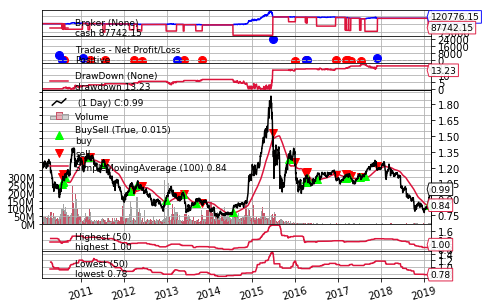

[[<matplotlib.figure.Figure at 0x1b3dbdec240>]]

In [60]:
cerebro.plot()

In [143]:
cerebro, strat = run_backtest(data, 100000, smaperiod = 5 , lmaperiod= 120, mwin=80)

{'smaperiod': 5, 'lmaperiod': 120, 'mwin': 80}
Starting Portfolio Value: 100000.00
buy 15200 at 2012-02-08 value:27968.0
0301 - 2012-03-29 - Position Size:     15200 - Value 99060.03  hold day: 35 d
buy 18200 at 2012-05-02 value:35490.0
0347 - 2012-06-08 - Position Size:     18200 - Value 97359.30  hold day: 27 d
buy 20300 at 2012-12-14 value:36905.4
0533 - 2013-03-18 - Position Size:     20300 - Value 98709.38  hold day: 58 d
buy 18800 at 2013-09-09 value:31584.0
0687 - 2013-11-08 - Position Size:     18800 - Value 96583.94  hold day: 37 d
buy 22800 at 2013-12-04 value:38326.8
0711 - 2013-12-12 - Position Size:     22800 - Value 94986.60  hold day: 6 d
buy 23300 at 2014-04-10 value:36138.299999999996
0801 - 2014-04-28 - Position Size:     23300 - Value 92606.87  hold day: 12 d
buy 35500 at 2014-07-14 value:52717.5
0922 - 2014-10-27 - Position Size:     35500 - Value 96218.72  hold day: 69 d
buy 26400 at 2014-11-12 value:45276.0
1086 - 2015-06-26 - Position Size:     26400 - Value 1202

In [149]:

datas = load_dir('.\data')
tags = datas.symbol.unique()
for file_index in range(len(tags)):
    tag = tags[file_index]
    print(tag)

    data = datas[datas.symbol== tag].iloc[:, 1:]
    data.index = pd.to_datetime(data.index)
    cerebro, strat = run_backtest(data, 100000, smaperiod = 5 , lmaperiod= 120, mwin=80)
    strat[0].analyzers.dd.print()
    strat[0].analyzers.yearreturn.print()

    


50ETF:510050
{'smaperiod': 5, 'lmaperiod': 120, 'mwin': 80}
Starting Portfolio Value: 100000.00
Final Portfolio Value: 433292.91
DrawDown:
  - len: 256
  - drawdown: 7.071977905881683
  - moneydown: 32974.31500000006
  -----------------------------------------------------------------------------
  - max:
    - len: 1293
    - drawdown: 13.985336307157832
    - moneydown: 57411.77360000007
TimeReturn:
  - 2005-12-31: 0.007760933999999997
  - 2006-12-31: 0.49467312949045095
  - 2007-12-31: 0.6582904888974956
  - 2008-12-31: -0.03943805049112892
  - 2009-12-31: 0.08597730052836439
  - 2010-12-31: -0.019492549866568676
  - 2011-12-31: -0.00803800669483623
  - 2012-12-31: 0.02342725257181355
  - 2013-12-31: -0.038477555834956045
  - 2014-12-31: 0.2938237633612373
  - 2015-12-31: 0.06738308311344499
  - 2016-12-31: 0.04027154420165835
  - 2017-12-31: 0.18935266110595106
  - 2018-12-31: -0.03985797662333579
  - 2019-12-31: 0.059059791027198605
中:159902
{'smaperiod': 5, 'lmaperiod': 120, 'mwin

Final Portfolio Value: 161756.71
DrawDown:
  - len: 905
  - drawdown: 22.46798338925024
  - moneydown: 46875.436200000084
  -----------------------------------------------------------------------------
  - max:
    - len: 905
    - drawdown: 25.59861904848451
    - moneydown: 53406.94860000006
TimeReturn:
  - 2013-12-31: -0.017123507000000093
  - 2014-12-31: 0.18450942849031993
  - 2015-12-31: 0.38897834184534985
  - 2016-12-31: -0.011405348475619026
  - 2017-12-31: -0.016406119745886905
  - 2018-12-31: 0.0
  - 2019-12-31: 0.02871551375994974
纳指ETF:513100
{'smaperiod': 5, 'lmaperiod': 120, 'mwin': 80}
Starting Portfolio Value: 100000.00
Final Portfolio Value: 99851.83
DrawDown:
  - len: 261
  - drawdown: 10.675177281715778
  - moneydown: 11933.256500000003
  -----------------------------------------------------------------------------
  - max:
    - len: 791
    - drawdown: 16.127374372706605
    - moneydown: 17304.879600000015
TimeReturn:
  - 2013-12-31: -0.006330480000000138
  - 2014

In [132]:
s0 = strat[0]

for a in s0.analyzers:
    print(a)

In [125]:
print(s0.analyzers[3].get_analysis())

OrderedDict([(datetime.date(2011, 12, 31), 0.0), (datetime.date(2012, 12, 31), 0.01930181899999983), (datetime.date(2013, 12, 31), -0.02566178781635231), (datetime.date(2014, 12, 31), 0.2205337554070368), (datetime.date(2015, 12, 31), 0.026870015054736962), (datetime.date(2016, 12, 31), 0.059670167538711016), (datetime.date(2017, 12, 31), 0.14761514158725375), (datetime.date(2018, 12, 31), -0.03378183257331291), (datetime.date(2019, 12, 31), 0.059049642915101286)])


In [150]:
tag = tags[0]
print(tag)

data = datas[datas.symbol== tag].iloc[:, 1:]
data.index = pd.to_datetime(data.index)
cerebro, strat = run_backtest(data, 100000, smaperiod = 5 , lmaperiod= 120, mwin=80)
strat[0].analyzers.r1.print()

50ETF:510050
{'smaperiod': 5, 'lmaperiod': 120, 'mwin': 80}
Starting Portfolio Value: 100000.00
Final Portfolio Value: 433292.91
Returns:
  - rtot: 1.4662437754417375
  - ravg: 0.0004298574539553613
  - rnorm: 0.11440884270245577
  - rnorm100: 11.440884270245578


In [151]:
(cerebro.broker.get_value()/100000) ** (1/float(14)) - 1

0.11041264472471912

In [136]:
s0.analyzers.ta.print()

TradeAnalyzer:
  -----------------------------------------------------------------------------
  - total:
    - total: 12
    - open: 1
    - closed: 11
  -----------------------------------------------------------------------------
  - streak:
    +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
    - won:
      - current: 0
      - longest: 2
    +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
    - lost:
      - current: 1
      - longest: 2
  -----------------------------------------------------------------------------
  - pnl:
    +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
    - gross:
      - total: 62522.69999999999
      - average: 5683.881818181817
    +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
    - net:
      - total: 61381.279899999994
      - average: 5580.116354545454
  -----------------------------------------------------------------------------
  - wo

D:\Anaconda3\lib\site-packages\matplotlib\__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


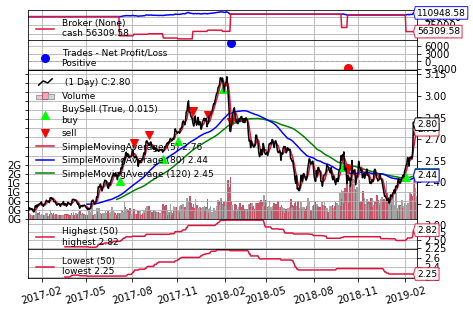

[[<matplotlib.figure.Figure at 0x21215deda90>]]

In [69]:
cerebro.plot()

D:\Anaconda3\lib\site-packages\matplotlib\__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


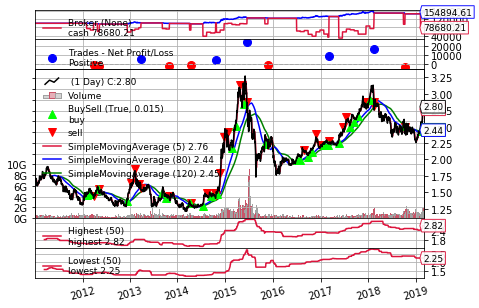

[[<matplotlib.figure.Figure at 0x21216063630>]]

In [87]:
cerebro.plot()

In [152]:
data.to_pickle('d:/test.pkl')